<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "9J"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/9J/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


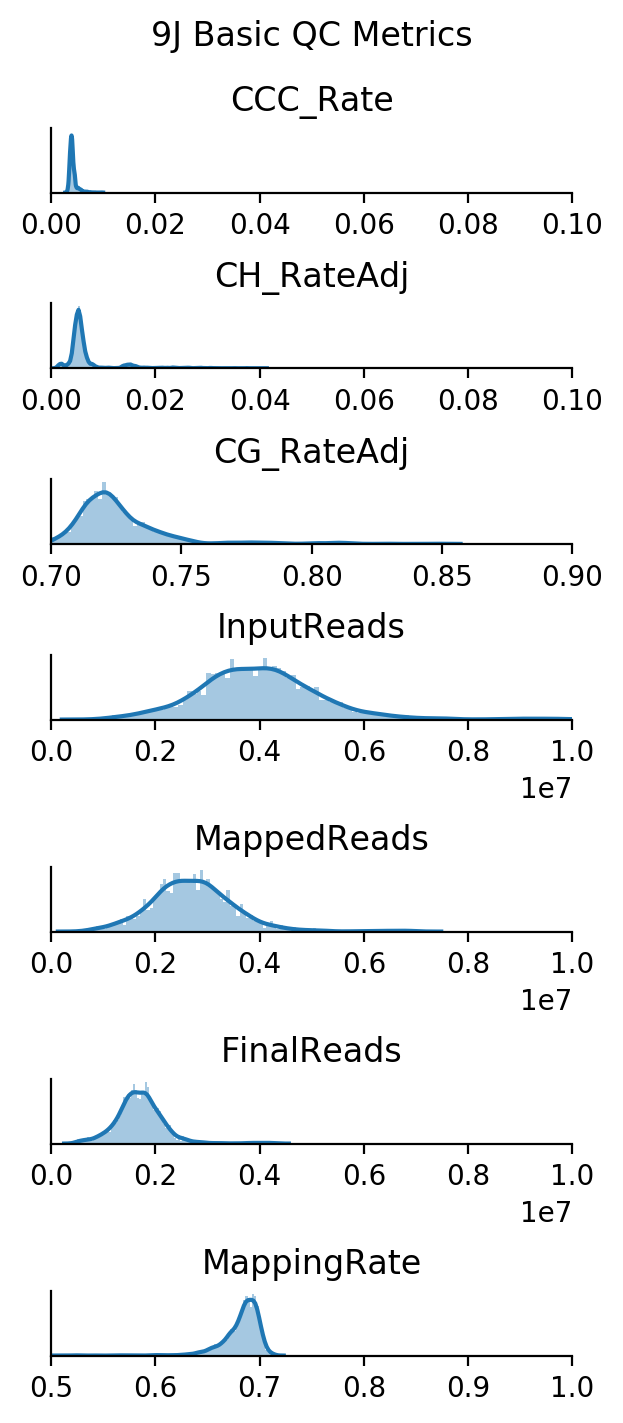

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

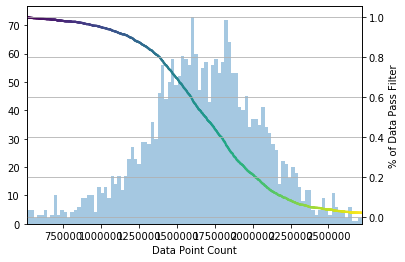

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2516/2516 (100.0%)
CG_RateAdj passed 2516/2516 (100.0%)
CH_RateAdj passed 2516/2516 (100.0%)
FinalReads passed 2516/2516 (100.0%)
MappingRate passed 2516/2516 (100.0%)
Overall passed 2516/2516 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
190212 1348
190219 1168


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 312 81.2%
ad002 323 84.1%
ad004 327 85.2%
ad006 329 85.7%
ad007 305 79.4%
ad008 306 79.7%
ad010 305 79.4%
ad012 309 80.5%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
9J_M_0,/gale/raidix/rdx-4/mapping/9J/CEMBA190212-9J-1...,0.004281,0.728456,0.727289,0.010462,0.006208,1182281.0,2562436,1715212.0,9J,...,-18.170050,-13.699653,-20.746048,0.221806,DG dg-all,-1.296727,-0.526865,-30.432901,4.903450,True
9J_M_10,/gale/raidix/rdx-4/mapping/9J/CEMBA190212-9J-1...,0.004580,0.718685,0.717390,0.010402,0.005848,1929543.0,4428816,2894449.0,9J,...,-18.617828,-9.329395,9.311726,-11.625946,DG dg-all,-3.282357,-8.555016,20.799491,16.260700,True
9J_M_1000,/gale/raidix/rdx-4/mapping/9J/CEMBA190212-9J-3...,0.004230,0.726585,0.725423,0.009947,0.005741,1703487.0,4147226,2890542.0,9J,...,-18.772497,-12.484532,-10.601272,-1.145499,DG dg-all,-3.045158,-2.758180,-25.102757,21.734557,True
9J_M_1001,/gale/raidix/rdx-4/mapping/9J/CEMBA190212-9J-3...,0.004731,0.720393,0.719064,0.009719,0.005012,1705009.0,4293462,2936219.0,9J,...,-18.697918,-8.562491,9.249915,0.937641,DG dg-all,-2.560798,-8.390107,11.432424,13.427422,True
9J_M_1002,/gale/raidix/rdx-4/mapping/9J/CEMBA190212-9J-3...,0.003996,0.713617,0.712468,0.008900,0.004924,1686276.0,4256080,2905053.0,9J,...,-19.255199,-8.963440,9.017334,-6.238058,DG dg-all,-2.998366,-9.174111,18.853517,19.144902,True
9J_M_1005,/gale/raidix/rdx-4/mapping/9J/CEMBA190212-9J-3...,0.004084,0.727201,0.726083,0.009222,0.005160,2386564.0,6105740,4170075.0,9J,...,-18.838112,-9.592045,8.768962,-6.630271,DG dg-all,-3.814249,-8.663583,21.687176,19.033912,True
9J_M_1006,/gale/raidix/rdx-4/mapping/9J/CEMBA190212-9J-3...,0.003781,0.704478,0.703356,0.007030,0.003261,1900191.0,4886266,3369528.0,9J,...,-17.813684,-3.988948,31.679839,0.332812,DG dg-all,-2.224267,-14.480588,45.292601,-2.535151,True
9J_M_1009,/gale/raidix/rdx-4/mapping/9J/CEMBA190212-9J-3...,0.004290,0.722833,0.721639,0.010027,0.005762,2010429.0,5155494,3561950.0,9J,...,-18.542690,-11.927708,-10.358936,2.345514,DG dg-all,-3.478769,-5.741973,-6.153708,19.123987,True
9J_M_1010,/gale/raidix/rdx-4/mapping/9J/CEMBA190212-9J-3...,0.003987,0.714946,0.713805,0.009494,0.005529,2102357.0,5230992,3561383.0,9J,...,-19.554306,-13.011271,-15.192258,-1.150466,DG dg-all,-3.157089,-2.736548,-18.886769,16.725279,True
9J_M_1011,/gale/raidix/rdx-4/mapping/9J/CEMBA190212-9J-3...,0.004107,0.720841,0.719690,0.009541,0.005457,2458274.0,6219550,4264540.0,9J,...,-19.762760,-12.622882,-8.648589,-8.531735,DG dg-all,-3.370228,-2.821978,-18.940834,17.094795,True
